<h1> <strong> <center> Problem Background: The Great Migration </center> </strong> </h1>

In our ongoing efforts to ensure the safety of the migration to Earth Junior, we have developed a linear regression model that produces a human-zombie score ranging from 0 to 100. This score is designed to assess the likelihood of individuals being human or zombie based on various features collected during screening.

To enhance our security measures, the spaceship station has deployed a specialized automated barrier system that utilizes the human-zombie scores to classify individuals into three distinct categories:

- **Class 0: Score Range 0-33**: **Most Likely Human**  
  Individuals in this range will be directed straight to the spaceship for immediate boarding.

- **Class 1: Score Range 33-66**: **Need Further Tests**  
  Those with scores in this range will be redirected to a testing facility for additional examinations to confirm their identity. They will be quarantined for a two-week observational period to ensure they do not pose a risk.

- **Class 3: Score Range 66-100**: **Most Likely Zombies**  
  Those scoring in this highest range will be denied entry to the spaceship, as they are deemed a significant threat to the safety of the remaining human population.

This classification system aims to maximize the chances of a successful migration while ensuring that the risk of zombie infiltration is minimized.

### Introduction

In this task, you will be applying Logistic Regression models for the provided dataset from scratch. A description of the problem statement is given at the start of this part.

After this notebook you should be able to:

- Implement a classifier using Logistic Regression.
- Create a Logistic Regression model using simple `numpy`.

<center>
  <img src = "https://miro.medium.com/v2/resize:fit:1100/format:webp/1*RElrybCZ4WPsUfRwDl7fqA.png">
</center>

One vs All (OvA) is a common technique to extend binary classifiers, like logistic regression, to handle multiclass classification tasks. For each class in the dataset, a logistic regression model is trained to distinguish that class from all other classes. For instance, for a `m` class classification, we will have `m` logistic regression classifiers in our pipeline. When making a prediction, each model outputs a probability that the instance belongs to its target class. The class with the highest probability across all models is chosen as the final prediction.

In this part, we will be going over how to implement a Multiclass Logistic Regression (OvA) model from scratch. For a review of this concept, you can go over the course slides or go over this [resource](https://www.cs.rice.edu/~as143/COMP642_Spring22/Scribes/Lect5).

## Import Libraries

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#### Dataset

In [231]:
df = pd.read_csv("human_zombie_dataset_v5.csv")

missing_values_count = df.isnull().sum()
print("Missing values per column:\n", missing_values_count)

for column in df.columns:
    if df[column].isnull().any():
        df[column].fillna(df[column].mean(), inplace=True)

Missing values per column:
 Height (cm)                     0
Weight (kg)                     0
Screen Time (hrs)               0
Junk Food (days/week)           0
Physical Activity (hrs/week)    0
Task Completion (scale)         0
Human-Zombie Score              0
dtype: int64


# Preprocessing

In this step, you will need to make several changes to the dataset before we can proceed with the analysis. Follow the guidelines below:

1. **Transform Labels**:  
   Convert the labels from continuous scores to categorical labels based on the class descriptions provided earlier.  
   This transformation is crucial for training the classifier effectively. 

2. **Perform Train-Test Split**:  
   Split the dataset into training and testing sets (8:2), and then check the sizes of both.  
   This step ensures that you have the right distribution of data for training and evaluation. 

3. **Normalize Data**:  
   Utilize the `Scaler` class that you created in Part 1 to normalize the features of the dataset. 

In [232]:
def transformLabels(score):
    if score >= 0 and score < 33:
        return 0
    elif score >= 33 and score < 66:
        return 1
    else:
        return 2

df['class_label'] = df['Human-Zombie Score'].apply(transformLabels)
df.drop(columns = ['Human-Zombie Score'], inplace= True)

In [233]:
X = df.drop(columns=['class_label'])
y = df['class_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Size of X train:", X_train.shape)
print("Size of X test:", X_test.shape)
print("Size of Y train:", y_train.shape)
print("Size of Y test:", y_test.shape)

Size of X train: (800, 6)
Size of X test: (200, 6)
Size of Y train: (800,)
Size of Y test: (200,)


In [234]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.stdev = None

    def fit(self, X):
        X = np.array(X)
        
        self.mean = np.mean(X, axis=0)
        self.stdev = np.std(X, axis=0)
        
    def transform(self, X):
        X = np.array(X)

        X_normalized = (X - self.mean) / (self.stdev)
        return X_normalized
    
scaler = StandardScaler()
scaler.fit(X_train)

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

## Part A: Implementation from Scratch  

Create a class, and implement the functionality described below to create a fully fledged **Regularized Logistic Regression model.**

* `sigmoid(x)`: This is the non-linear "activation" function that differentiates Logistic from plain-old Linear Regression. Refer to the formula from the slides. 

* `cross_entropy_loss(y_true, y_pred)`: This is the loss function that will help you calculate the gradients for updating your model. Note that this is a Binary Classification task so you can use the Binary Cross Entropy function mentioned in the slides. 

* `fit(x_train, y_train)`: This will be where you implement the Gradient Descent algorithm again, keeping in mind the differences between Linear and Logistic Regression. 

* `predict(x_test)`: predict whether the label is 0 or 1 for test reviews using learned logistic regression (use the decision threshold of 0.5) **Note: you need to return the probability and the predicted label from this function** 

* `evaluate(y_true, y_pred)` function that calculates classification accuracy, F1 Score and confusion matrix. 

In [235]:
class LogisticRegression:
    def __init__(self, alpha, epochs, lambd):
        self.alpha = alpha
        self.epochs = epochs
        self.lambd = lambd
        self.thetas = None
        self.loss_values = [] 

    def sigmoid(self, x):
        sigmoid = 1 / (1 + np.exp(-x))
        return sigmoid

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = ((-1 / m) * np.sum((y_true * np.log(y_pred)) + ((1 - y_true) * np.log(1 - y_pred)))) + (self.lambd * np.sum(np.abs(self.thetas[1:])))
        return loss

    def fit(self, x_train, y_train):
        x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))        
        m = x_train.shape[0]
        n = x_train.shape[1] 
        self.thetas = np.zeros(n)
        
        for i in range(self.epochs):
            z = np.dot(x_train, self.thetas)
            y_predicted = self.sigmoid(z)
            
            gradients = (1 / m) * np.dot(x_train.T, (y_predicted - y_train))
            gradients[1:] = gradients[1:] + ((self.lambd) * np.sign(self.thetas[1:]))
            
            self.thetas = self.thetas - (self.alpha * gradients)
            
            loss = self.cross_entropy_loss(y_train, y_predicted)
            self.loss_values.append(loss)

    def predict(self, x_test):
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))        
        probabilities = self.sigmoid(np.dot(x_test, self.thetas))
        predicted_label = np.where(probabilities >= 0.5, 1, 0)        
        return probabilities, predicted_label

    def evaluate(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        confusion_matrix_result = confusion_matrix(y_true, y_pred)
        return accuracy, f1, confusion_matrix_result

# Implement One vs All Classification  

You need to build four classifiers, one for each class, and perform the following steps for each:

1. Create a plot with the number of iterations/epochs on the x-axis and training/validation loss on the y-axis for the evaluation dataset that we separated previously.

2. Tune the hyperparameters, i.e., learning rate and number of epochs, to minimize the validation loss.

Train Cross-Entropy Loss for class 0: 0.1181


Train Cross-Entropy Loss for class 1: 0.6164
Train Cross-Entropy Loss for class 2: 0.1166


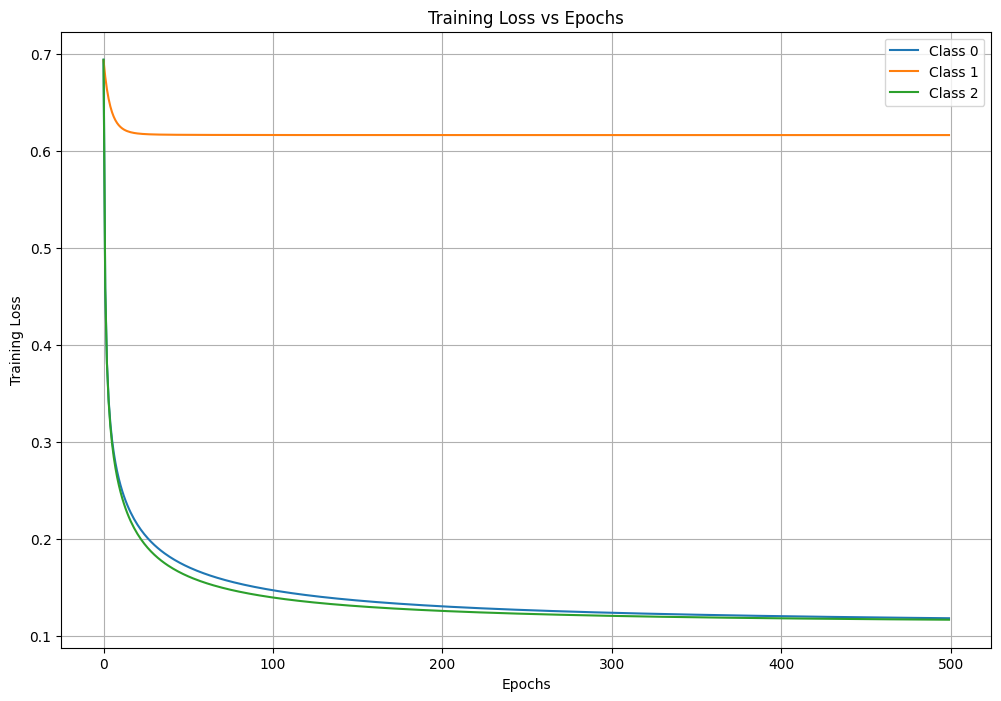

In [236]:
# One-vs-Rest Classifiers
classifiers = {}
losses = {}  

alpha = 0.5
epochs = 500
lambd = 0.001

plt.figure(figsize=(12, 8))

for i in range(3):    
    y_binary = (y_train == i).astype(int) 
    classifier = LogisticRegression(alpha= alpha, epochs= epochs, lambd= lambd)
    classifier.fit(X_train_normalized, y_binary)
    classifiers[i] = classifier
    losses[i] = classifier.loss_values

    plt.plot(range(len(losses[i])), losses[i], label=f'Class {i}')
    
    y_train_probabilities, y_train_labels = classifier.predict(X_train_normalized)
    train_cross_entropy = classifier.cross_entropy_loss(y_binary, y_train_probabilities)
    print(f"Train Cross-Entropy Loss for class {i}: {train_cross_entropy:.4f}")

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Evaluate  

It's time to run your logistic regression model on the test dataset!

- Report the accuracy, F1 score and confusion matrix for each binary classifier 
- Perform multiclass evaluation and report macro F1, accuracy and confusion matrix 

In [237]:
# Evaluate each binary classifier
results = {
    'Class': [],
    'Probs':[],
    'Accuracy': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

for i in range(3):  
    y_test_binary = (y_test == i).astype(int)  
    y_test_probabilities, y_test_labels = classifiers[i].predict(X_test_normalized)  
    accuracy, f1, cm = classifiers[i].evaluate(y_test_binary, y_test_labels)
    
    results['Class'].append(i)
    results['Probs'].append(y_test_probabilities) 
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    results['Confusion Matrix'].append(cm)

results_df = pd.DataFrame(results)
print(results_df)

   Class                                              Probs  Accuracy  \
0      0  [0.6655492944814225, 0.004740301062810128, 0.9...     0.960   
1      1  [0.35323262728747357, 0.293938092720599, 0.240...     0.620   
2      2  [0.0002927972271216079, 0.11116134756143833, 4...     0.955   

   F1 Score     Confusion Matrix  
0  0.936508  [[133, 6], [2, 59]]  
1  0.000000  [[124, 0], [76, 0]]  
2  0.930233  [[131, 6], [3, 60]]  


In [238]:
results_df.drop('Probs', axis= 1, inplace=True)
print(results_df)

   Class  Accuracy  F1 Score     Confusion Matrix
0      0     0.960  0.936508  [[133, 6], [2, 59]]
1      1     0.620  0.000000  [[124, 0], [76, 0]]
2      2     0.955  0.930233  [[131, 6], [3, 60]]


In [239]:
class_labels = ['Class 0: Most Likely Human', 
                'Class 1: Further Testing', 
                'Class 2: Most Likely Zombie']

highest_probability_class = np.argmax(np.column_stack([results['Probs'][i] for i in range(3)]) , axis=1)  # Choose class with highest probability for each instance
predicted_class_labels = [class_labels[label] for label in highest_probability_class]

In [240]:
macro_f1 = f1_score(y_test, highest_probability_class, average='macro')
multiclass_accuracy = accuracy_score(y_test, highest_probability_class)
multiclass_confusion_matrix = confusion_matrix(y_test, highest_probability_class)

print(f"Macro F1 Score: {macro_f1 * 100:.2f}%")
print(f"Multiclass Accuracy: {multiclass_accuracy * 100:.2f}%")
print("Confusion Matrix for Multiclass Classification:")
print(multiclass_confusion_matrix)

Macro F1 Score: 88.53%
Multiclass Accuracy: 88.50%
Confusion Matrix for Multiclass Classification:
[[61  0  0]
 [11 56  9]
 [ 0  3 60]]


# Part B: Use Scikit-learn  

In this part, use scikit-learn’s [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation to train and test the logistic regression on the provided dataset.

Use scikit-learn’s `accuracy_score` function to calculate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), F1 score and [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to calculate confusion matrix on test set.

Finally, plot the confusion matrix

Accuracy: 91.00%
Macro F1 Score: 91.17%
Confusion Matrix:
[[59  2  0]
 [ 6 64  6]
 [ 0  4 59]]


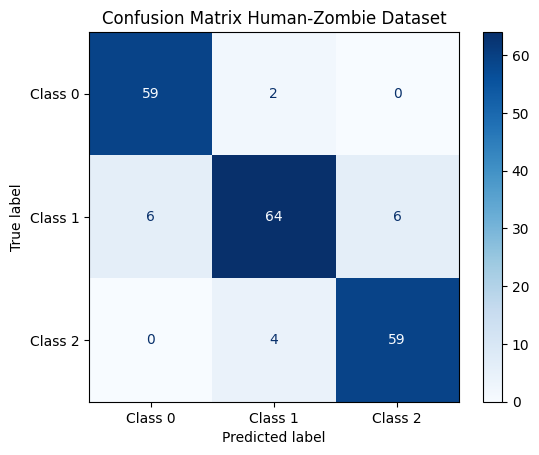

In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

LR_sklearn = LogisticRegression(multi_class= 'multinomial')
LR_sklearn.fit(X_train_normalized, y_train)
y_predicted = LR_sklearn .predict(X_test_normalized)

accuracy = accuracy_score(y_test, y_predicted)
macro_f1 = f1_score(y_test, y_predicted, average='macro')
confusion_matrix_result = confusion_matrix(y_test, y_predicted)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Macro F1 Score: {macro_f1 * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix_result)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result, display_labels=['Class 0', 'Class 1', 'Class 2'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Human-Zombie Dataset")
plt.show()

# Part C: Are You a Zombie?  
Use your multiclass classifier to predict whether you are a zombie.

In [242]:
height = 180              # Height in cm
weight = 81              # Weight in kg
screen_time = 8         # Screen time in hours per day
junk_food_days = 3       # Junk food consumption in days per week
physical_activity = 8    # Physical activity in hours per week
task_completion = 8      # Task completion on a scale (example range: 1-10)

In [243]:
test_point = np.array([height, weight, screen_time, junk_food_days, physical_activity, task_completion])
test_point = scaler.transform(test_point)  

In [244]:
labels = {0: "Human", 1: "Needs Further Testing", 2: "Zombie"}
probs=[]
for i in range(3):  
    y_pred_class, prob = classifiers[i].predict(test_point.reshape(1,-1))    
    probs.append(prob)
combined_probs = np.column_stack([p for p in probs])
multi_class_pred = np.argmax(combined_probs, axis=1)
print("Prediction:", labels[multi_class_pred[0]])

Prediction: Human
